In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

In [2]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./out_cnfmr")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 32
EPOCHS = 400
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_improv_cnfmr_bs2_model.keras"

In [3]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753703670.891180      10 service.cc:148] XLA service 0x5a7b8d940f90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753703670.891223      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753703670.891236      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753703670.891239      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753703670.891242      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753703670.891244      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753703670.891247      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753703670.891249      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753703670.891252      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 256


In [5]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [6]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")
print(f"New X_test shape: {X_test.shape}")
print(f"New X_val shape: {X_val.shape}")

Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)
New X_test shape: (3906, 150, 768)
New X_val shape: (3676, 150, 768)


In [7]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [8]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False, drop_remainder = False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True, drop_remainder=True)
val_dataset = prepare_dataset(X_val, y_val, shuffle=False, drop_remainder=True)
test_dataset = prepare_dataset(X_test, y_test, shuffle=False, drop_remainder=True)
print("Datasets created successfully.")


Building tf.data pipeline
Datasets created successfully.


In [22]:
with strategy.scope():
    print("\nBuilding Conformer Model")

    # Conformer Block
    def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Convolution Module
        x_conv = layers.LayerNormalization()(x)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
        x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.Activation("swish")(x_conv)
        x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1)(x_conv)
        x_conv = layers.Dropout(dropout)(x_conv)
        x = x + x_conv # Residual connection

        # Attention Module
        x_attn = layers.LayerNormalization()(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Module
        x_ff = layers.LayerNormalization()(x)
        x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection

        return x

    def build_conformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs

        # Applies Conformer blocks
        x = conformer_block(x, num_heads=4, ff_dim=1028)
        x = conformer_block(x, num_heads=4, ff_dim=1028)

        # Pools the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)

        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc_roc'), 
             tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
        )
        return model

    model = build_conformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")


Building Conformer Model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 150, 1536) │  1,181,184 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_4  │ (None, 150, 1536) │      6,144 │ conv1d_8[0][0]    │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 1536) │      6,144 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 150, 1536) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 150, 768)  │  1,180,416 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 150, 768)  │          0 │ conv1d_9[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 150, 768)  │          0 │ input_layer_2[0]… │
│                     │                   │            │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 150, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 150, 768)  │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 768)  │      1,536 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 150, 1028) │    790,532 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 150, 1028) │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 150, 768)  │    790,272 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 150, 768)  │          0 │ add_13[0][0],     │
│                     │                   │            │ dense_13[0][0]  

 Total params: 12,742,413 (48.61 MB)

 Trainable params: 12,736,269 (48.59 MB)

 Non-trainable params: 6,144 (24.00 KB)

LEARNING RATE: 1e-05
BATCH SIZE: 256


In [23]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc_pr', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc_pr', mode='max', patience=10, restore_best_weights=True, verbose=1)


In [ ]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753706616.337663      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9597456326934924708
I0000 00:00:1753706618.057469     933 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11555090129527494429), session_name()
I0000 00:00:1753706636.019728     933 tpu_compile_op_common.cc:245] Compilation of 11555090129527494429 with session name  took 17.962215623s and succeeded
I0000 00:00:1753706636.079697     933 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11555090129527494429), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9597456326934924708", property.function_library_fingerprint = 7036112970771190790, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2659 - auc_pr: 0.4278 - auc_roc: 0.5822 - loss: 0.6626 - precision: 0.4684 - recall: 0.2747

I0000 00:00:1753706661.789795      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17756550174407769531
I0000 00:00:1753706662.071654     935 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5690916503341650374), session_name()
I0000 00:00:1753706664.048813     935 tpu_compile_op_common.cc:245] Compilation of 5690916503341650374 with session name  took 1.977117725s and succeeded
I0000 00:00:1753706664.056560     935 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5690916503341650374), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_17756550174407769531", property.function_library_fingerprint = 12416963676894098685, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().


Epoch 1: val_auc_pr improved from -inf to 0.55181, saving model to out_cnfmr/best_improv_cnfmr_bs2_model.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.2660 - auc_pr: 0.4283 - auc_roc: 0.5827 - loss: 0.6622 - precision: 0.4691 - recall: 0.2742 - val_accuracy: 0.2818 - val_auc_pr: 0.5518 - val_auc_roc: 0.6566 - val_loss: 0.6443 - val_precision: 0.7749 - val_recall: 0.0417
Epoch 2/400
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3099 - auc_pr: 0.5205 - auc_roc: 0.6525 - loss: 0.6206 - precision: 0.5647 - recall: 0.3013
Epoch 2: val_auc_pr did not improve from 0.55181
116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.3099 - auc_pr: 0.5206 - auc_roc: 0.6526 - loss: 0.6205 - precision: 0.5647 - recall: 0.3013 - val_accuracy: 0.2631 - val_auc_pr: 0.5359 - val_auc_roc: 0.6443 - val_loss: 0.6424 - val_precision: 0.6198 - val_recall: 0.1634
Epoch 3/400
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3247 - auc_pr: 0.5474 - auc_roc: 0.6774 - loss: 0.6


--- Evaluating Model on the Test Set ---


I0000 00:00:1753704894.074068      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:10103496736430959938
E0000 00:00:1753704894.111362      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/batch_normalization_1/Cast/ReadVariableOp.
I0000 00:00:1753704894.216797     950 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5755658590466699794), session_name()
I0000 00:00:1753704895.736536     950 tpu_compile_op_common.cc:245] Compilation of 5755658590466699794 with session name  took 1.51970359s and succeeded
I0000 00:00:1753704895.739919     950 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5755658590466699794), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_10103496736430959938", property.function_library_fingerprint = 6724956111832801141, property.mlir_module_f

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.67      0.46      0.55      1335
       Block       0.62      0.48      0.54      1982
    SoundRep       0.56      0.45      0.50       886
     WordRep       0.49      0.47      0.48       917
Interjection       0.89      0.66      0.76      1833

   micro avg       0.67      0.52      0.58      6953
   macro avg       0.65      0.50      0.56      6953
weighted avg       0.67      0.52      0.59      6953
 samples avg       0.61      0.53      0.54      6953


--- Generating plots for model training history... ---


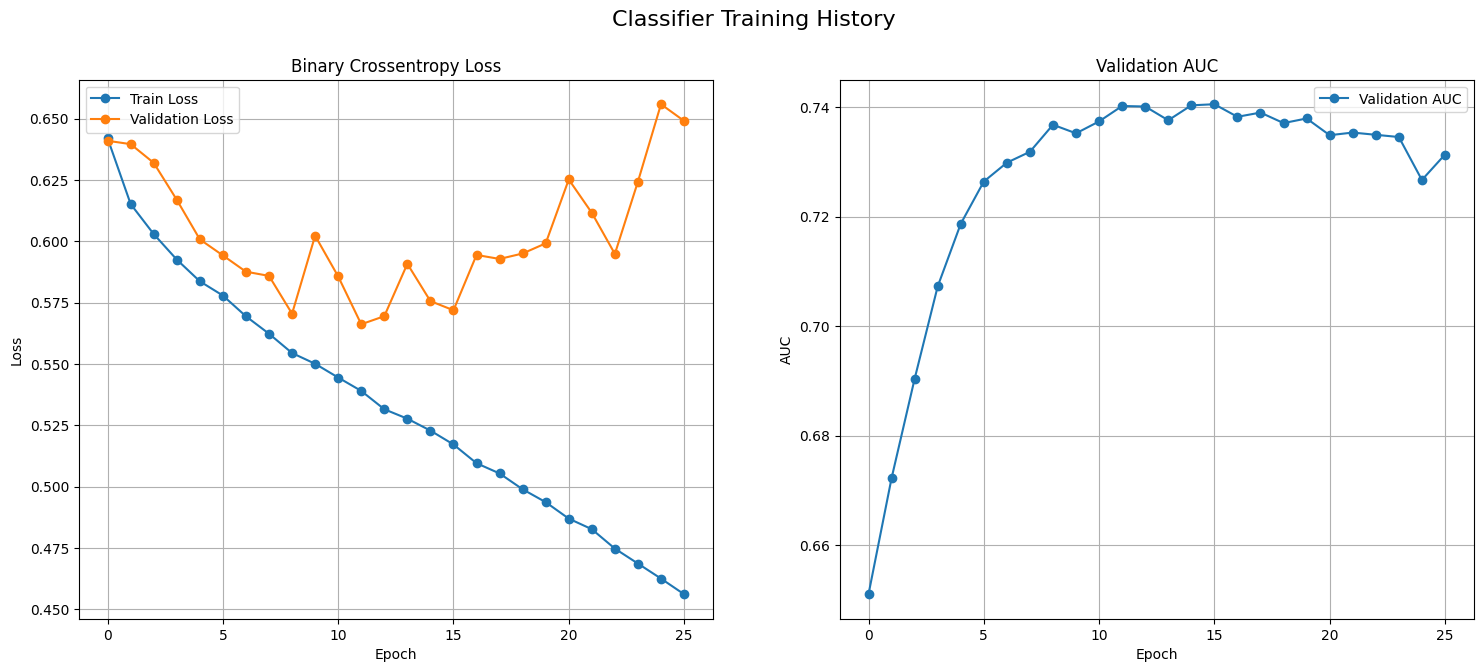

In [12]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---


I0000 00:00:1753706163.559192      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8156473667964164382
E0000 00:00:1753706163.599442      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753706163.703424     959 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3124887565890542947), session_name()
I0000 00:00:1753706165.153414     959 tpu_compile_op_common.cc:245] Compilation of 3124887565890542947 with session name  took 1.449938661s and succeeded
I0000 00:00:1753706165.159470     959 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3124887565890542947), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8156473667964164382", property.function_library_fingerprint = 14376217404737287622, property.mlir_modu

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.67      0.39      0.50      1335
       Block       0.65      0.36      0.47      1982
    SoundRep       0.58      0.42      0.49       886
     WordRep       0.49      0.50      0.49       917
Interjection       0.86      0.60      0.71      1833

   micro avg       0.67      0.46      0.54      6953
   macro avg       0.65      0.45      0.53      6953
weighted avg       0.68      0.46      0.54      6953
 samples avg       0.56      0.47      0.48      6953


--- Generating plots for model training history... ---


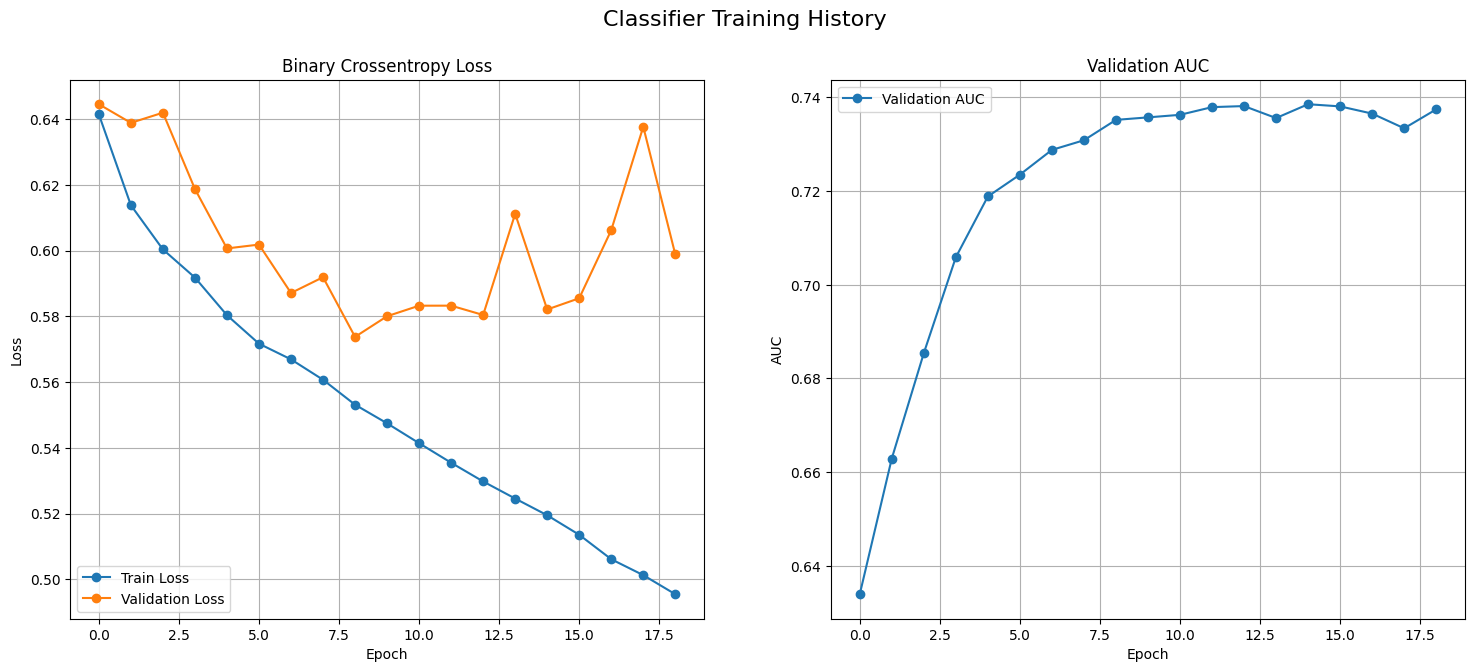

In [ ]:
# Monitor: Val_loss

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()


--- Evaluating Model on the Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.63      0.52      0.57      1335
       Block       0.64      0.41      0.50      1982
    SoundRep       0.55      0.44      0.49       886
     WordRep       0.54      0.42      0.47       917
Interjection       0.86      0.66      0.74      1833

   micro avg       0.67      0.50      0.57      6953
   macro avg       0.64      0.49      0.56      6953
weighted avg       0.67      0.50      0.57      6953
 samples avg       0.60      0.52      0.52      6953


--- Generating plots for model training history... ---


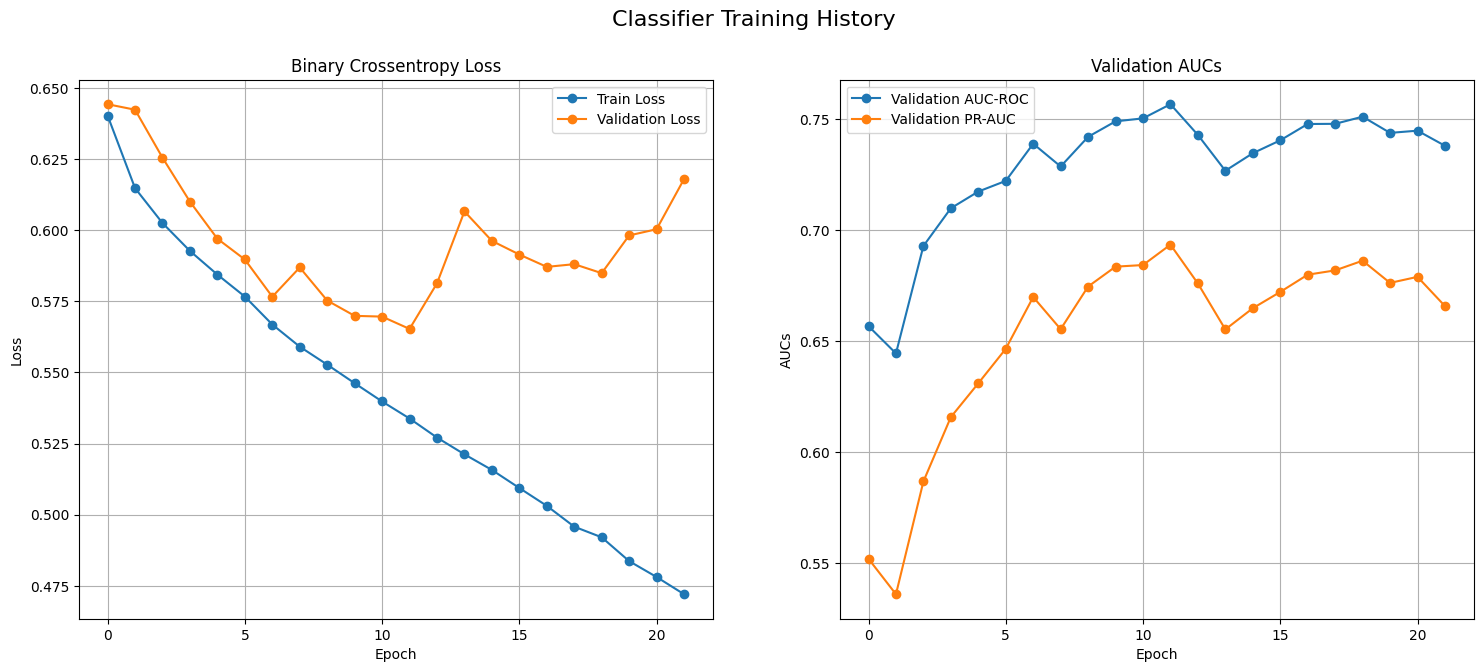

In [ ]:
# Monitor: Val_auc_pr

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation AUC-ROC')
ax2.plot(history_dict['val_auc_pr'], 'o-', label='Validation PR-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUCs'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()